# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M')) #get dummies es para realizar las variables dummies se supone que estan ordenadas por valor
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
import pandas as pd
import numpy as np

In [6]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

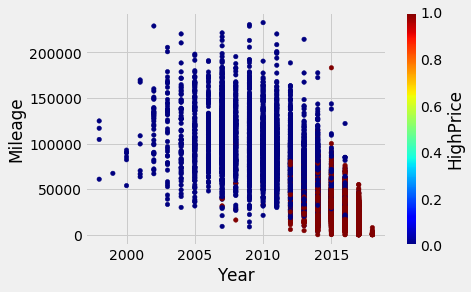

In [7]:
# scatter plot of Years versus Hits colored by Price
data.plot(kind='scatter', x='Year', y='Mileage', c='HighPrice', colormap='jet')

In [8]:
feature_cols = data.columns.drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [9]:
data.HighPrice.describe()

count    13150.000000
mean         0.579544
std          0.493651
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HighPrice, dtype: float64

In [10]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [11]:
j = 1
print(X_train.columns[j])

Mileage


In [12]:
# Split the variable in num_ctp points
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [13]:
splits = np.unique(splits)

In [14]:
splits

array([6.000000e+00, 1.603480e+04, 2.324080e+04, 2.987540e+04,
       3.565100e+04, 4.160950e+04, 4.849280e+04, 6.199830e+04,
       8.097420e+04, 1.061537e+05])

In [15]:
k = 5

In [16]:
filter_l = X_train.iloc[:, j] < splits[k]

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [17]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [18]:
gini_l = gini(y_l)
gini_l

0.20474618023837854

In [19]:
gini_r = gini(y_r)
gini_r

0.3959988713681828

In [20]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [21]:
gini_impurity(X_train.iloc[:, j], y_train, splits[k])

0.18743041714283493

In [22]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain guarda el mejor sin historico
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain] # Aqui se guarda (Variable, Particion(en valores) , ganancia)
    
    return best_split

In [23]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(1, 56598.66666666667, 0.23507164147905313)

In [24]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [25]:
y_train.shape[0], y_l.shape[0], y_r.shape[0]

(8810, 5873, 2937)

In [26]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.8205346500936489, 0.09329247531494722)

In [27]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain= -1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [28]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [29]:
def tree_predict(X, tree, proba=False): #X es igual a X_test
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted  

In [30]:
y_pred=tree_predict(X_test, tree)

In [31]:
from sklearn import metrics
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.882798833819242, 0.8610599078341014)

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np

In [33]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [34]:
# show the rows for the first decision tree
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
358005,2013,82246,1,0,0,0,0,0,0
137970,2016,38701,0,0,0,0,1,0,0
272337,2017,14302,0,0,0,0,0,1,0
354913,2017,35268,0,0,0,0,0,1,0
138402,2014,6455,0,0,0,0,0,1,0
144693,2002,89851,0,1,0,0,0,0,0
100267,2009,53337,0,0,0,0,1,0,0
255124,2015,49150,0,0,0,0,0,0,1
344262,2016,20205,0,0,0,0,1,0,0
32368,2017,20006,0,0,0,0,0,1,0


In [35]:
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [36]:

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_trainB = X_train.iloc[sample]
    y_trainB = y_train.iloc[sample]
    treereg= tree_grow(X_trainB, y_trainB, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred[i] = tree_predict(X_test, treereg)

In [37]:
y_pred.head(10)

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205915,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2836,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
250833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
y_pred0 = (y_pred.sum(axis=1) >= (10 / 2)).astype(np.int)

In [39]:
metrics.f1_score(y_pred0, y_test), metrics.accuracy_score(y_pred0, y_test)

(0.8915617365156926, 0.8670506912442396)

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features 

Evaluate the accuracy on the testing set

In [40]:
np.int(np.log(len(X_train.columns)))

2

In [41]:
# Function that create the tree, with the parameter max_features
def tree_grow0(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None, random_state=None):
    
    np.random.seed(random_state)
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    else:
        
        
        if max_features != None:
          
            max_feat = max_features
            feat=np.random.choice(a=len(X.columns), size=max_feat, replace=False)
            feat.sort()
            X = X.iloc[:,feat]

        
    
    j, split, gain = best_split(X, y, num_pct)
    
   
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  
    
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
  
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [42]:
Result=pd.DataFrame(columns=['Accuracy','f1 Score'],data=[])

for i in range(0,X_train.shape[1]+1):
    tree = tree_grow0(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=i, random_state=1)
    y_pred = pd.DataFrame(tree_predict(X_test, tree))
    Result.loc[i] = [metrics.accuracy_score(y_pred, y_test),metrics.f1_score(y_pred, y_test)]

In [43]:
Result

,Accuracy,f1 Score
0,0.582488,0.736168
1,0.582488,0.736168
2,0.582488,0.736168
3,0.582488,0.736168
4,0.582488,0.736168
5,0.582488,0.736168
6,0.861060,0.882799
7,0.861060,0.882799
8,0.861060,0.882799
9,0.861060,0.882799


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [44]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [45]:
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [46]:

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_trainB = X_train.iloc[sample]
    y_trainB = y_train.iloc[sample]
    treereg= tree_grow0(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=np.int(np.log(len(X_train.columns))), random_state=1)
    y_pred[i] = tree_predict(X_test, treereg)

In [47]:
y_pred.head(10)

,0,1,2,3,4,5,6,7,8,9
332784,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
330419,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
205915,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2836,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
250833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126784,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [48]:
y_pred0 = (y_pred.sum(axis=1) >= (10 / 2)).astype(np.int)

In [49]:
metrics.f1_score(y_pred0, y_test), metrics.accuracy_score(y_pred0, y_test)

(0.7361677344205009, 0.5824884792626728)

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
RandomF = RandomForestClassifier(n_estimators=10,random_state=1)
RandomF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [52]:
y_pred1 = RandomF.predict(X_test)

In [53]:
metrics.f1_score(y_pred1, y_test), metrics.accuracy_score(y_pred1, y_test)

(0.8615751789976134, 0.83963133640553)

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [54]:
from sklearn.model_selection import RandomizedSearchCV

In [55]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
RanF = RandomForestClassifier(n_estimators=10,random_state=1)

In [57]:
rf_random = RandomizedSearchCV(estimator = RanF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

In [58]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [59]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [60]:
RandomF = RandomForestClassifier(n_estimators=600,random_state=1,max_features='auto',max_depth=10)
RandomF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [61]:
y_pred1 = RandomF.predict(X_test)

In [62]:
metrics.f1_score(y_pred1, y_test), metrics.accuracy_score(y_pred1, y_test)

(0.8994263862332694, 0.8788018433179724)